In [1]:
#import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #For plotting
from sklearn.cluster import KMeans #Do K-Means clustering
from sklearn.metrics import silhouette_score #Calculate score of silhouette for each K
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator #Find the knee of the WCSS vs K plot
from yellowbrick.cluster import silhouette_visualizer #Plot Silhouette plot
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
#Importing the dataset
officeLat_data = pd.read_excel('RentalOfficeData_Location_JanNov2018.xlsx')
officeLat_data.head()

,Unnamed: 0,month,code,rentals,returns,location_map,latitude,logitude
0,0,201806,101.0,832,807,"(37.549561, 126.905754)",37.549561,126.905754
1,1,201806,102.0,2819,2568,"(37.5556488, 126.9106293)",37.555649,126.910629
2,2,201806,103.0,1977,1769,"(37.55495071, 126.9108353)",37.554951,126.910835
3,3,201806,104.0,1682,1610,"(37.55062866, 126.9149857)",37.550629,126.914986
4,4,201806,105.0,1105,925,"(37.55000687, 126.9148254)",37.550007,126.914825


In [3]:
officeLat_data.drop(columns= ['month', 'location_map', 'Unnamed: 0'], inplace = True) #these columns are not useful in our groupings 
officeLat_data.head()

,code,rentals,returns,latitude,logitude
0,101.0,832,807,37.549561,126.905754
1,102.0,2819,2568,37.555649,126.910629
2,103.0,1977,1769,37.554951,126.910835
3,104.0,1682,1610,37.550629,126.914986
4,105.0,1105,925,37.550007,126.914825


In [4]:
df_new_Clust = officeLat_data.copy()

In [9]:
df_new_Clust = df_new_Clust.groupby('code').mean().reset_index()
df_new_Clust.head()

,code,rentals,returns,latitude,logitude
0,101.0,546.583333,551.666667,37.549561,126.905754
1,102.0,2028.333333,1860.166667,37.555649,126.910629
2,103.0,1410.583333,1270.416667,37.554951,126.910835
3,104.0,1267.083333,1180.083333,37.550629,126.914986
4,105.0,807.166667,668.916667,37.550007,126.914825


In [10]:
df_new_Clust_copy = df_new_Clust.copy()

In [11]:
df_new_Clust.drop(columns= ['code'],inplace=True) #these columns are not useful in our groupings 
df_new_Clust.head()

,rentals,returns,latitude,logitude
0,546.583333,551.666667,37.549561,126.905754
1,2028.333333,1860.166667,37.555649,126.910629
2,1410.583333,1270.416667,37.554951,126.910835
3,1267.083333,1180.083333,37.550629,126.914986
4,807.166667,668.916667,37.550007,126.914825


In [12]:
df_new_Clust.describe()

,rentals,returns,latitude,logitude
count,1490.000000,1490.000000,1449.000000,1449.000000
mean,641.816108,638.017503,37.521267,126.903127
std,536.038546,568.086362,0.987730,3.337257
min,0.000000,0.000000,0.000000,0.000000
25%,281.145833,257.500000,37.505463,126.917130
50%,512.083333,497.100000,37.546532,127.003944
75%,853.541667,866.958333,37.577621,127.058083
max,6192.416667,5921.083333,37.689720,127.180267


In [15]:
#Removing all rows with empty values
nan_value = float("NaN")
#Convert NaN values to empty string

df_new_Clust.replace("", nan_value, inplace=True)

#df.dropna(subset = ["column2"], inplace=True)
df_new_Clust.dropna(subset = ["latitude"], inplace=True)


In [41]:
df_new_Clust_copy.replace("", nan_value, inplace=True)
df_new_Clust_copy.dropna(subset = ["latitude"], inplace=True)

In [16]:
df_new_Clust.describe()

,rentals,returns,latitude,logitude
count,1449.000000,1449.000000,1449.000000,1449.000000
mean,645.840485,641.946896,37.521267,126.903127
std,539.848843,572.208178,0.987730,3.337257
min,0.000000,0.000000,0.000000,0.000000
25%,282.166667,257.916667,37.505463,126.917130
50%,513.083333,497.833333,37.546532,127.003944
75%,855.900000,868.750000,37.577621,127.058083
max,6192.416667,5921.083333,37.689720,127.180267


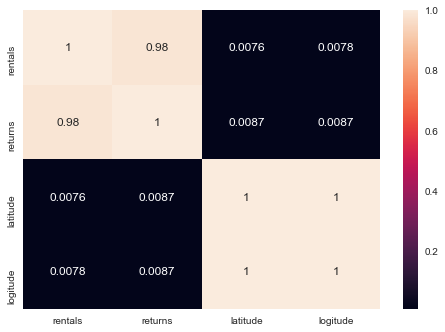

In [17]:
corrMatrix = df_new_Clust.corr()
sns.heatmap(corrMatrix, annot=True, annot_kws={"size": 12})
plt.show()

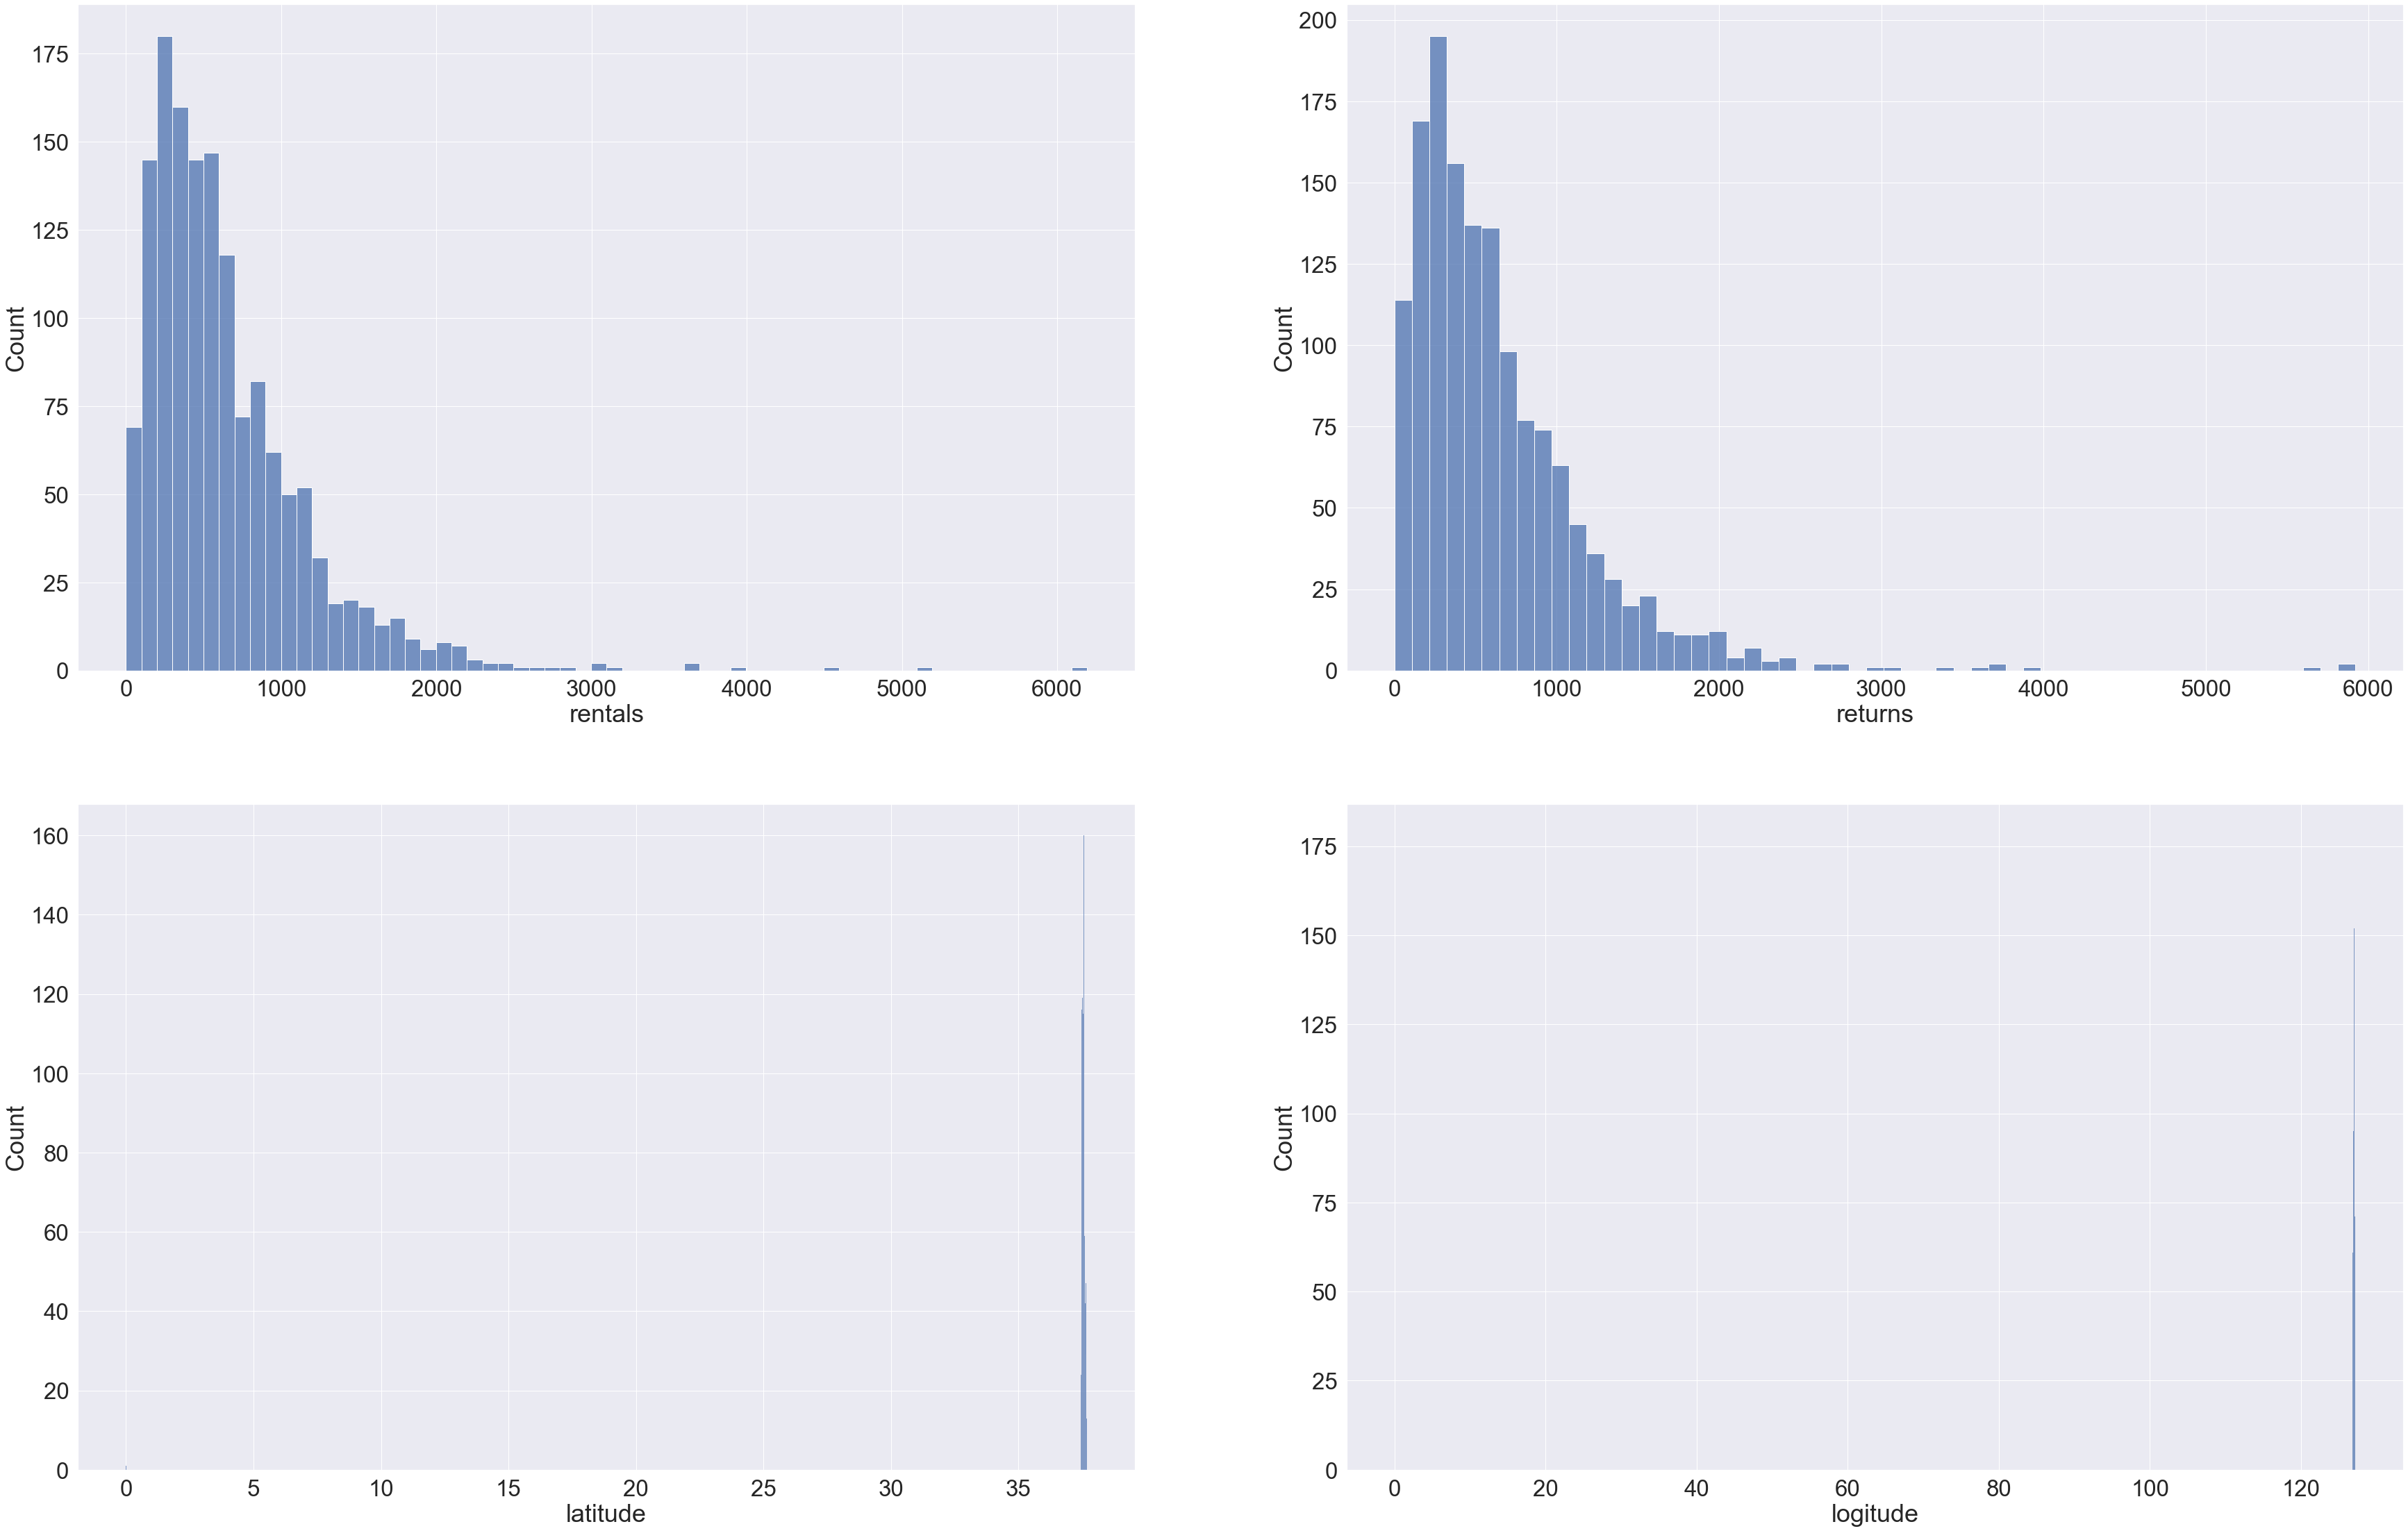

In [18]:
#Do a visual check to get a sense on how we can group some features
plt.figure(figsize=(60,60))
sns.set(font_scale = 3)
for i in range(len(df_new_Clust.columns)):
    plt.subplot(3,2,i+1)
    freshplot = sns.histplot(df_new_Clust.iloc[:,i])

In [19]:
#if the columns are too skewed, this is a method that scales each column of a dataframe, the output is a numpy array 
dataarray = df_new_Clust.to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) #Scaling inputs if required

### Elbow method with Total WCSS vs Number of Clusters

In [20]:
wcss = []
max_k = 14 # NOTE: Try 10 and 20
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dataarray)
    wcss.append(kmeans.inertia_)

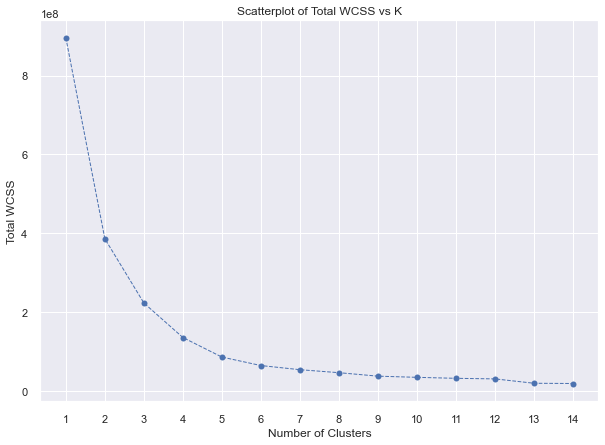

In [21]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [22]:
#To locate the elbow point of the curve using kneed package
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

4

### Silhouette width plot

In [23]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dataarray)
    score = silhouette_score(dataarray, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

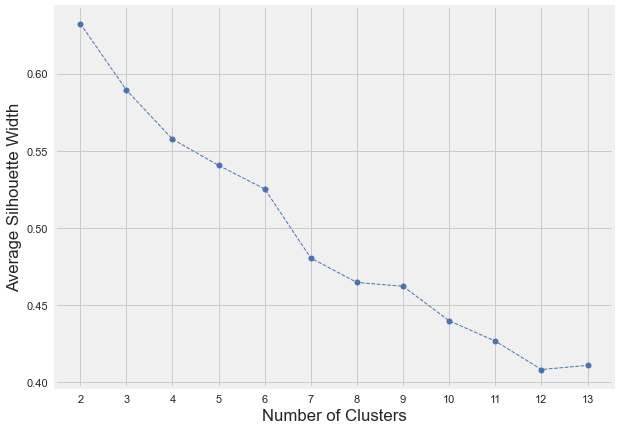

In [24]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

### Running the K-means on scaled data

In [26]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

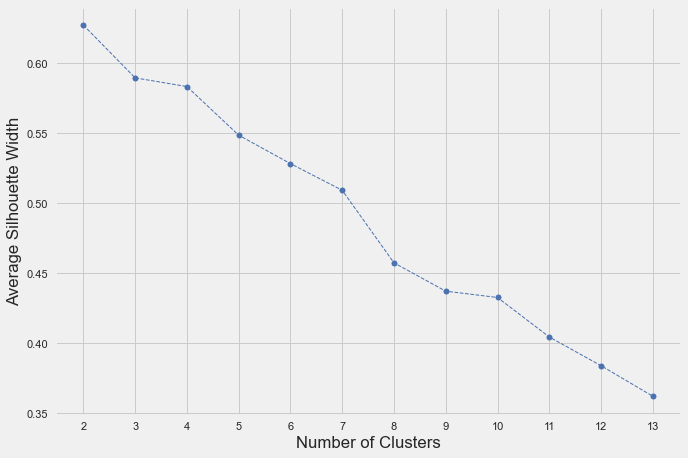

In [27]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

### K-Means Clustering Algorithm Implementation

In [28]:
#silhouette dictionary to track the silhouette scores for different k 
silhouette_dict = {}

In [29]:
#Fit kmeans labels onto our dataframe
#Input: df and int, Output:df 
def kmeans_label(data, num_clusters): 
  kmeans_model = KMeans(init = 'random', n_clusters = num_clusters, random_state=42)
  kmeans_model.fit(data.to_numpy())
  data2 = data.copy()
  labels = kmeans_model.labels_
  data2['Clusters'] = pd.DataFrame(labels)
  return data2

In [30]:
#Plot boxplots of each feature after attaching cluster label in each row
#Input: df with labels, Output: plt graphs
def plot_boxplots(data_with_label):
  plt.figure(figsize=(30,30))
  sns.set(font_scale = 2)
  for i in range(len(data_with_label.columns)-1):
    plt.subplot(3,3,i+1)
    sns.boxplot(y=data_with_label.columns[i], x='Clusters', data=data_with_label, palette="colorblind") 


In [31]:
#Plot the silhouettes
#Input: df, Output: plt graphs
def plot_silhouettes(data,num_clusters):
  dataarray = data.to_numpy()
  model = KMeans(num_clusters,random_state=42)
  plt.figure(figsize=(10, 7)) 
  sns.set(font_scale = 1)
  silhouette_visualizer(model, dataarray, colors='yellowbrick')
  score = silhouette_score(dataarray, model.labels_,metric = 'euclidean')
  if num_clusters not in silhouette_dict.keys():
    silhouette_dict[num_clusters] = score
  print("For n_clusters = {0} The average silhouette_score is: {1} ".format(num_clusters,score))


### K-means with 4 clusters <Rentals, Returns, Lat, Long>

In [33]:
kmeans4 = KMeans(init="random",n_clusters =4 , random_state = 42)
kmeans4.fit(dataarray)
clustergroups4 = kmeans4.labels_ #The cluster number for each row

In [34]:
Clustercenters4 = pd.DataFrame(kmeans4.cluster_centers_) #Dataframe of cluster centers
Clustercenters4.rename(columns={0: "Num_Rental", 1: "Num_Return", 2: "Latitute", 3: "longitude"},inplace=True)
Clustercenters4.index.name = "Clusters"

In [35]:
Clustercenters4

,Num_Rental,Num_Return,Latitute,longitude
Clusters,,,,
0,3607.782051,3847.361538,37.534726,126.984640
1,818.882724,826.195606,37.547076,126.995520
2,311.086283,287.709513,37.500050,126.830705
3,1570.624944,1611.564536,37.550897,126.988977


In [36]:
from decimal import Decimal
print(kmeans4.inertia_)
print('%.1E' % Decimal(kmeans4.inertia_))

136463557.95253006
1.4E+08


In [37]:
model4 = kmeans_label(df_new_Clust, 4) #Attach kmeans_labels to our markets_data
model4.head() # which cluster each row belongs to

,rentals,returns,latitude,logitude,Clusters
0,546.583333,551.666667,37.549561,126.905754,3.0
1,2028.333333,1860.166667,37.555649,126.910629,1.0
2,1410.583333,1270.416667,37.554951,126.910835,1.0
3,1267.083333,1180.083333,37.550629,126.914986,1.0
4,807.166667,668.916667,37.550007,126.914825,0.0


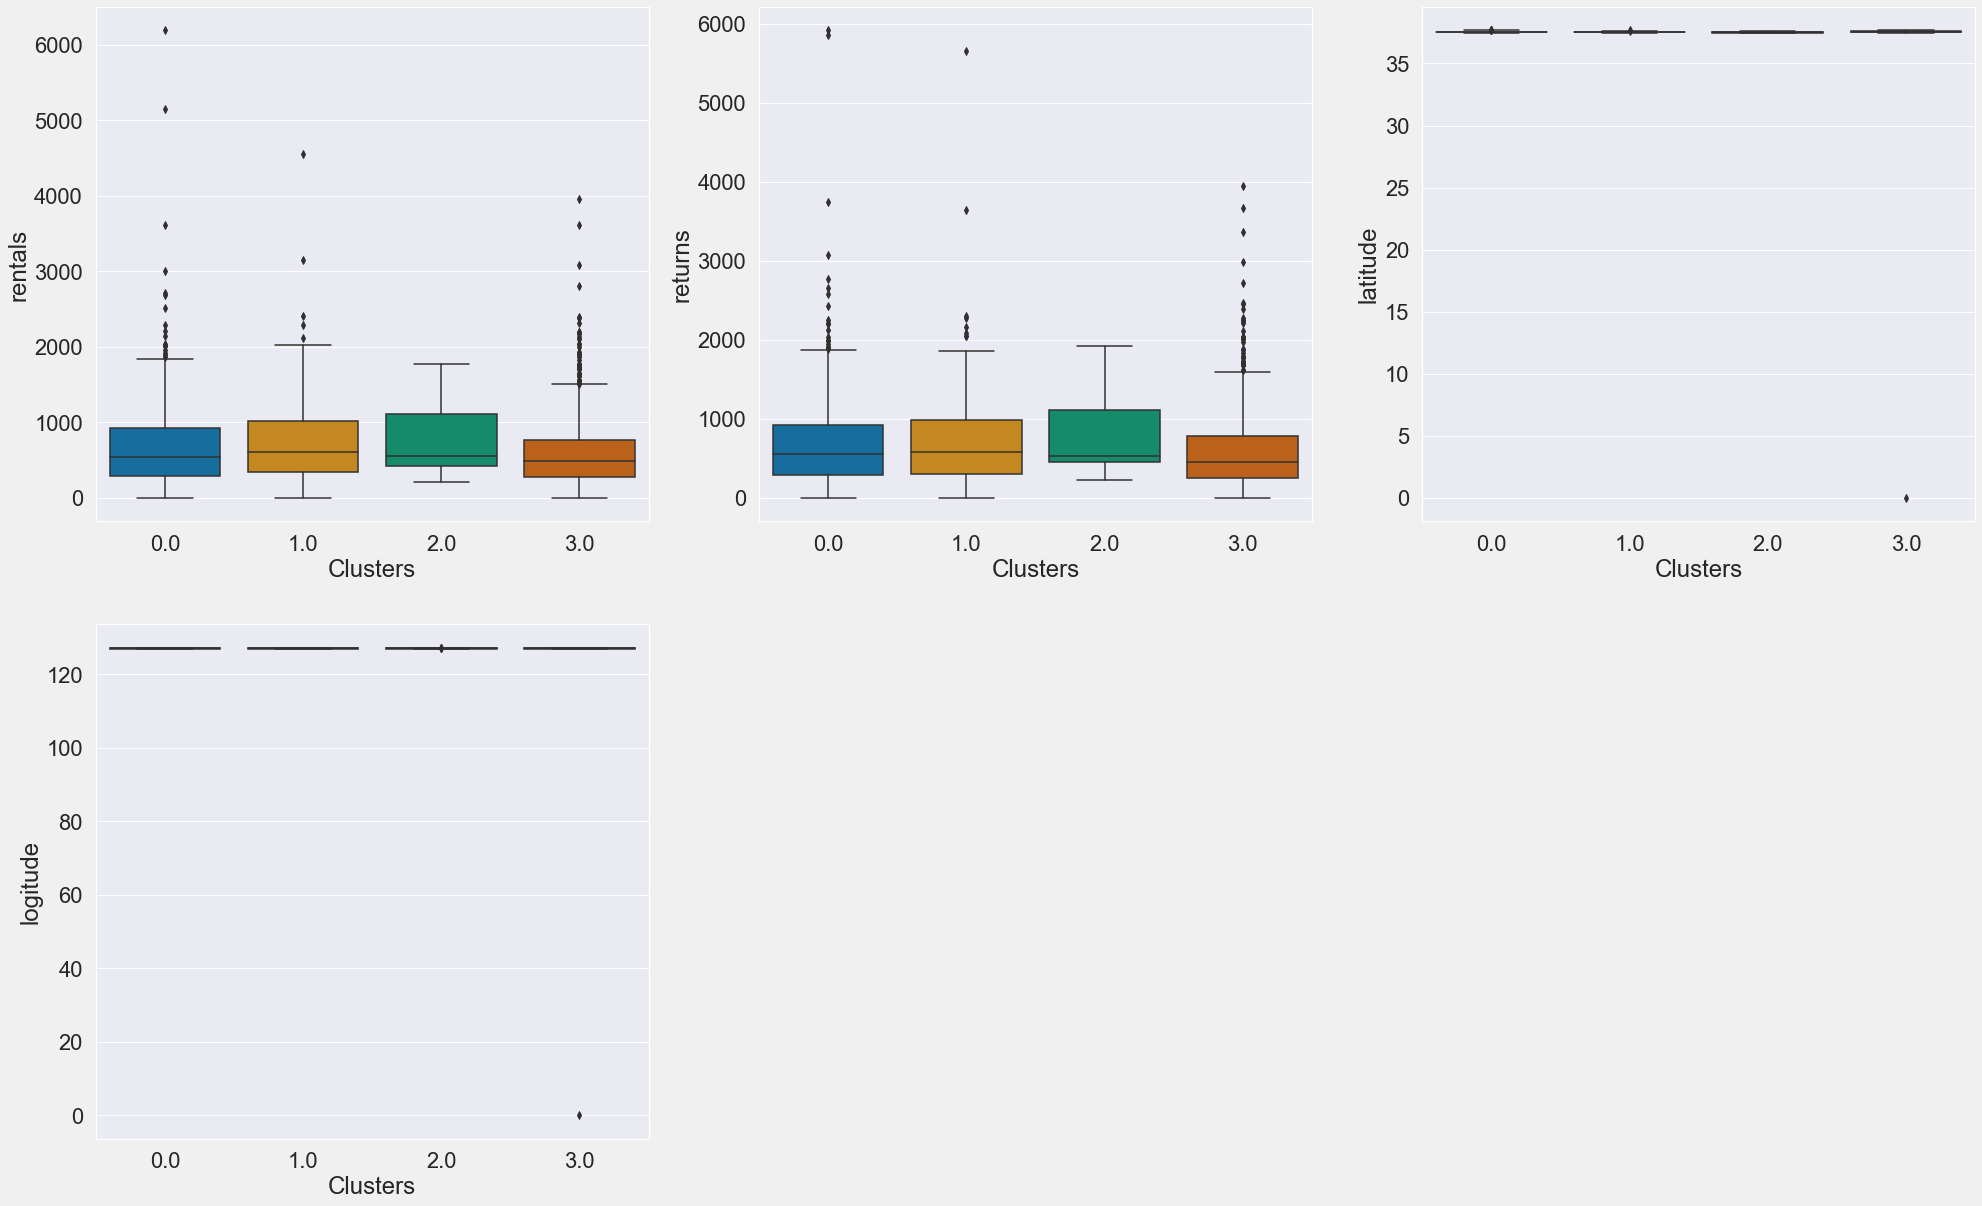

In [38]:
plot_boxplots(model4)

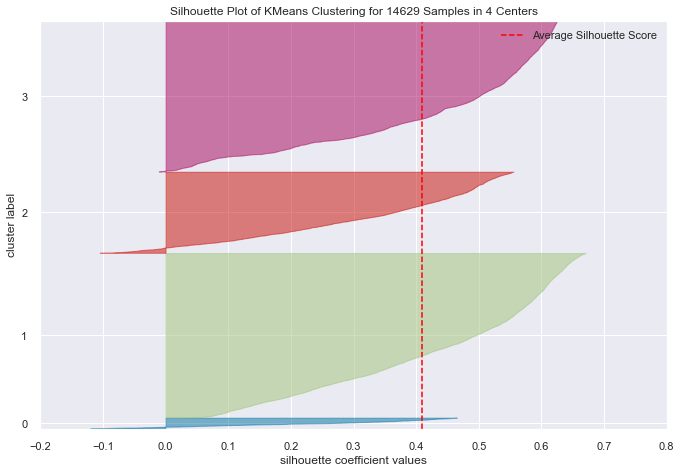

For n_clusters = 4 The average silhouette_score is: 0.40854620257439234 


In [39]:
plot_silhouettes(officeLat_data,4)

In [40]:
model4.Clusters.value_counts(dropna = False)

3.0    784
0.0    454
1.0    160
NaN     38
2.0     13
Name: Clusters, dtype: int64

In [44]:
df_new_Clust_copy.shape

(1449, 5)

In [45]:
model4.shape

(1449, 5)

In [46]:
df_new_Clust_copy

,code,rentals,returns,latitude,logitude
0,101.0,546.583333,551.666667,37.549561,126.905754
1,102.0,2028.333333,1860.166667,37.555649,126.910629
2,103.0,1410.583333,1270.416667,37.554951,126.910835
3,104.0,1267.083333,1180.083333,37.550629,126.914986
4,105.0,807.166667,668.916667,37.550007,126.914825
...,...,...,...,...,...
1484,3534.0,1278.000000,1277.000000,37.540138,127.069282
1485,3535.0,229.500000,260.000000,37.559158,127.087517
1486,3536.0,545.000000,535.000000,37.531811,127.080742
1487,3537.0,267.000000,204.000000,37.548489,127.093758


In [47]:
model4

,rentals,returns,latitude,logitude,Clusters
0,546.583333,551.666667,37.549561,126.905754,3.0
1,2028.333333,1860.166667,37.555649,126.910629,1.0
2,1410.583333,1270.416667,37.554951,126.910835,1.0
3,1267.083333,1180.083333,37.550629,126.914986,1.0
4,807.166667,668.916667,37.550007,126.914825,0.0
...,...,...,...,...,...
1484,1278.000000,1277.000000,37.540138,127.069282,NaN
1485,229.500000,260.000000,37.559158,127.087517,NaN
1486,545.000000,535.000000,37.531811,127.080742,NaN
1487,267.000000,204.000000,37.548489,127.093758,NaN


In [55]:
model4 = model4.reset_index()

In [48]:
df_merge = df_new_Clust_copy.reset_index()[['index','code']]
df_merge

,index,code
0,0,101.0
1,1,102.0
2,2,103.0
3,3,104.0
4,4,105.0
...,...,...
1444,1484,3534.0
1445,1485,3535.0
1446,1486,3536.0
1447,1487,3537.0


In [57]:
final_df = pd.merge(model4, df_merge[["code", "index"]], on = "index", how = "left")

In [58]:
final_df

,index,rentals,returns,latitude,logitude,Clusters,code
0,0,546.583333,551.666667,37.549561,126.905754,3.0,101.0
1,1,2028.333333,1860.166667,37.555649,126.910629,1.0,102.0
2,2,1410.583333,1270.416667,37.554951,126.910835,1.0,103.0
3,3,1267.083333,1180.083333,37.550629,126.914986,1.0,104.0
4,4,807.166667,668.916667,37.550007,126.914825,0.0,105.0
...,...,...,...,...,...,...,...
1444,1484,1278.000000,1277.000000,37.540138,127.069282,NaN,3534.0
1445,1485,229.500000,260.000000,37.559158,127.087517,NaN,3535.0
1446,1486,545.000000,535.000000,37.531811,127.080742,NaN,3536.0
1447,1487,267.000000,204.000000,37.548489,127.093758,NaN,3537.0


In [59]:
final_df.to_excel("ClustersDf_V2.xlsx")

### Clustering on <Rentals, Lat, Lon>

In [61]:
df_clust2 = df_new_Clust_copy.copy()
df_clust2.drop(columns= ['code', 'returns'],inplace=True) #these columns are not useful in our groupings 
df_clust2.head()

,rentals,latitude,logitude
0,546.583333,37.549561,126.905754
1,2028.333333,37.555649,126.910629
2,1410.583333,37.554951,126.910835
3,1267.083333,37.550629,126.914986
4,807.166667,37.550007,126.914825


In [63]:
df_clust2.describe()

,rentals,latitude,logitude
count,1449.000000,1449.000000,1449.000000
mean,645.840485,37.521267,126.903127
std,539.848843,0.987730,3.337257
min,0.000000,0.000000,0.000000
25%,282.166667,37.505463,126.917130
50%,513.083333,37.546532,127.003944
75%,855.900000,37.577621,127.058083
max,6192.416667,37.689720,127.180267


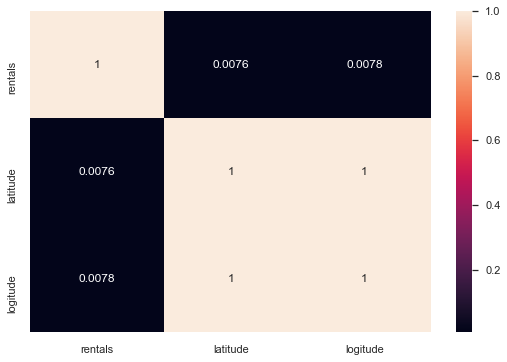

In [64]:
corrMatrix = df_clust2.corr()
sns.heatmap(corrMatrix, annot=True, annot_kws={"size": 12})
plt.show()

In [65]:
#if the columns are too skewed, this is a method that scales each column of a dataframe, the output is a numpy array 
dataarray = df_clust2.to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) #Scaling inputs if required

In [66]:
wcss = []
max_k = 14 # NOTE: Try 10 and 20
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dataarray)
    wcss.append(kmeans.inertia_)

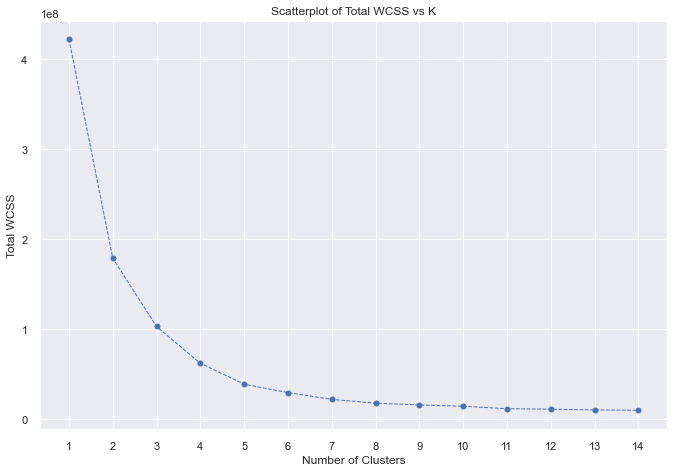

In [67]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [68]:
#To locate the elbow point of the curve using kneed package
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

4

In [69]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dataarray)
    score = silhouette_score(dataarray, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

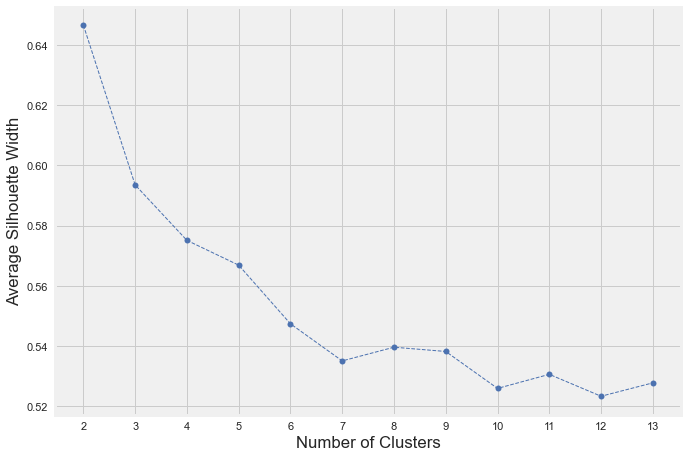

In [70]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

In [71]:
#silhouette dictionary to track the silhouette scores for different k 
silhouette_dict = {}

In [72]:
kmeans4 = KMeans(init="random",n_clusters =4 , random_state = 42)
kmeans4.fit(dataarray)
clustergroups4 = kmeans4.labels_ #The cluster number for each row

In [73]:
Clustercenters4 = pd.DataFrame(kmeans4.cluster_centers_) #Dataframe of cluster centers
Clustercenters4.rename(columns={0: "Num_Rental", 1: "Latitute", 2: "logitude"},inplace=True)
Clustercenters4.index.name = "Clusters"

In [74]:
Clustercenters4

,Num_Rental,Latitute,logitude
Clusters,,,
0,831.367500,37.547411,126.993971
1,1622.488522,37.550753,126.992093
2,3708.506944,37.529329,126.990288
3,307.795016,37.499719,126.829827


In [76]:
model4 = kmeans_label(df_clust2, 4) #Attach kmeans_labels to our markets_data
model4.head() # which cluster each row belongs to

,rentals,latitude,logitude,Clusters
0,546.583333,37.549561,126.905754,3.0
1,2028.333333,37.555649,126.910629,1.0
2,1410.583333,37.554951,126.910835,1.0
3,1267.083333,37.550629,126.914986,1.0
4,807.166667,37.550007,126.914825,0.0


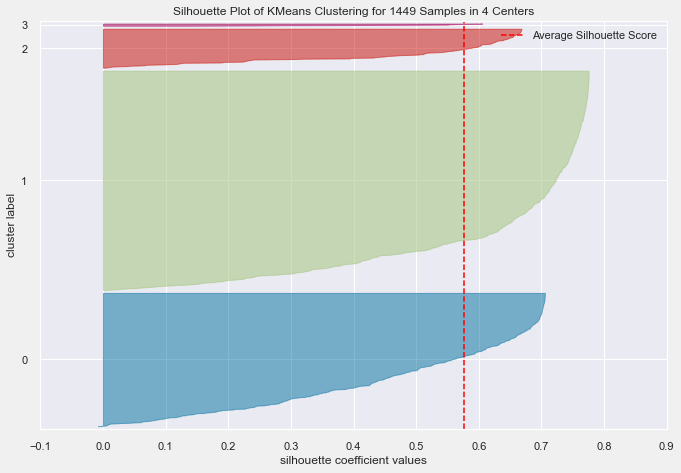

For n_clusters = 4 The average silhouette_score is: 0.5759865594759711 


In [77]:
plot_silhouettes(df_clust2,4)

In [78]:
model4.Clusters.value_counts(dropna = False)

3.0    780
0.0    477
1.0    142
NaN     38
2.0     12
Name: Clusters, dtype: int64

In [79]:
model4 = model4.reset_index()

In [80]:
df_merge2 = df_new_Clust_copy.reset_index()[['index','code']]
df_merge2


,index,code
0,0,101.0
1,1,102.0
2,2,103.0
3,3,104.0
4,4,105.0
...,...,...
1444,1484,3534.0
1445,1485,3535.0
1446,1486,3536.0
1447,1487,3537.0


In [81]:
final_df = pd.merge(model4, df_merge2[["code", "index"]], on = "index", how = "left")
final_df


,index,rentals,latitude,logitude,Clusters,code
0,0,546.583333,37.549561,126.905754,3.0,101.0
1,1,2028.333333,37.555649,126.910629,1.0,102.0
2,2,1410.583333,37.554951,126.910835,1.0,103.0
3,3,1267.083333,37.550629,126.914986,1.0,104.0
4,4,807.166667,37.550007,126.914825,0.0,105.0
...,...,...,...,...,...,...
1444,1484,1278.000000,37.540138,127.069282,NaN,3534.0
1445,1485,229.500000,37.559158,127.087517,NaN,3535.0
1446,1486,545.000000,37.531811,127.080742,NaN,3536.0
1447,1487,267.000000,37.548489,127.093758,NaN,3537.0


In [82]:
final_df.to_excel("ClustersDf_V3.xlsx")